## Import

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import spacy


from tqdm import tqdm

from millenlp.preprocessing import PreProc
from millenlp.embeddings import FastTextVec, TfidfVec
from millenlp.state_models.shallow_model import ShallowModel

from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.manifold import TSNE
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from graphviz import Digraph

from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric
from gensim.corpora import WikiCorpus
from gensim.models import FastText

/opt/conda/envs/nlp/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## function definitions

In [2]:
def ranking_by_label_prediction(data_set,model,label):
    data_set['Prediction'] = data_set['iteration'].apply(lambda x : model._classifier.predict(model._vectorizer.transform([model.preprocessing(x)]))[0])
    data_set[model._classifier.classes_] = pd.DataFrame(data_set['iteration'].apply(lambda x : model._classifier.predict_proba(model._vectorizer.transform([model.preprocessing(x)]))[0]).values.tolist(), 
                                                                                index= data_set.index)
    return data_set.sort_values([label], ascending = [0])

def vocabulary(model, label_to_sort):
    
    if 'FastText' is model._vectorizer._embedding.__class__.__name__:
        classes = model._classifier.classes_
        word_dict = list(model._vectorizer._embedding.wv.vocab.keys())

        features_words = pd.DataFrame(model._vectorizer.transform(word_dict), 
                                      columns = list(range(model._vectorizer._num_features)))
        features_words = features_words.astype(float)

        features_ranked = pd.DataFrame(word_dict, columns = ['feature'])
        for i, label in enumerate(classes):
            topics = [label_to_sort] if len(model._classifier.classes_) < 3 else model._classifier.classes_.tolist()
            ranking_dim = pd.DataFrame(np.transpose(model._classifier.coef_), columns=topics)
            ranking_dim['feature'] = list(range(model._vectorizer._num_features))
            ranking_dim = ranking_dim.round(2).sort_values(label_to_sort, ascending=False).reset_index(drop=True)
            ranking_dim = ranking_dim[ranking_dim[model._classifier.classes_].idxmax(axis=1)==label]

            feature_weight = pd.DataFrame()
            features_words_filtered = features_words[ranking_dim.feature.tolist()]
            feature_weight[label] = np.dot(features_words_filtered.values,
                                           ranking_dim[label_to_sort].values) / features_words_filtered.shape[1]
            features_ranked = pd.concat([features_ranked,feature_weight], axis = 1)

        features_ranked = features_ranked.sort_values(by=[label_to_sort], ascending = False)
        
    elif 'TfidfVectorizer' is model._vectorizer._embedding.__class__.__name__:
        
        topics = [label_to_sort] if len(model._classifier.classes_) < 3 else model._classifier.classes_.tolist()
#         topics = model._classifier.classes_.tolist()
        features_ranked = pd.DataFrame(np.transpose(model._classifier.coef_), columns=topics)
        features_ranked['feature'] = model._vectorizer._embedding.get_feature_names()
        features_ranked = features_ranked.round(2).sort_values(label_to_sort, ascending=False).reset_index(drop=True)
        
    return features_ranked

def node_coef(data_set,coef_features,msg_col,label_col,feature,per_class):
    if per_class:
        data_set = data_set[data_set.label == label_col]
    count_feature = data_set[data_set[msg_col].str.contains(feature)].shape[0]
    if feature in coef_features.feature.values:
        coef = coef_features[coef_features.feature.isin([feature])][label_col].values[0]
    else:
        coef = 'Not in Dict'
    feature_info = pd.DataFrame(np.array([[feature,count_feature,round(coef,2)]]),
                                      columns = ['feature','counts','coef'])
    return feature_info 

def prob_around_word(data_set,coef_features,regex,msg_col,label_col, feature, per_class):
    
    if per_class:
        data_set = data_set[data_set.label == label_col]
        
    regex = regex.replace('{}',feature)
    look_around = data_set[msg_col].str.extract(regex, expand=False)
    count_feature = data_set[data_set[msg_col].str.contains(feature)].shape[0]
    
    if isinstance(look_around, pd.DataFrame):
        look_around = look_around.iloc[:,-1]
        
    look_around = look_around.dropna().value_counts().to_frame().reset_index()  
    look_around.columns = ['feature','counts']
    look_around['probability'] = np.divide(look_around.counts.values,np.sum(look_around.counts.values))*100
    look_around['coef'] = [round(coef_features[coef_features.feature.isin([word])][label_col].values[0],2)
                           if word in coef_features.feature.values else 'Not in Dict' 
                           for word in look_around.feature.values]
    return look_around

def left_parents(data_set, child, graph, dot):
    for parent in data_set.feature.values:
        data = data_set[data_set.feature==parent]
        if parent in list(graph.keys()):
            graph[parent][child] = (data.probability.values[0],
                                    data.counts.values[0],
                                    data.coef.values[0])
            dot = set_graph_atr(dot, data.coef.values[0])
            dot.node(parent,'{} \n Count = {} \n Coef = {}'.format(parent,
                                                                   data.counts.values[0],
                                                                   data.coef.values[0]),
                    shape='plaintext')
            dot.edge(parent, child,label = ('{}%'.format(str(round(data.probability.values[0],2)))),weight='1.2')
        else:
            graph[parent] = {child: (data.probability.values[0],
                                     data.counts.values[0],
                                     data.coef.values[0])}
            dot = set_graph_atr(dot, data.coef.values[0])
            dot.node(parent,'{} \n Count = {} \n Coef = {}'.format(parent,
                                                                   data.counts.values[0],
                                                                   data.coef.values[0]),
                    shape='plaintext')
            dot.edge(parent, child,label = ('{}%'.format(str(round(data.probability.values[0],2)))),weight='1.2')
    return graph, dot

def right_child(data_set, parent, graph,dot):
    if parent in list(graph.keys()):
        graph[parent] = {**graph[parent],**dict(zip(data_set.feature.values,
                                                   zip(data_set.probability.values,
                                                       data_set.counts.values,
                                                      data_set.coef.values)))}
        for child, counts, prob, coef in data_set.values:
            dot = set_graph_atr(dot, coef)
            dot.node(child,'{} \n Count = {} \n Coef = {}'.format(child,
                                                                  counts,
                                                                  coef),shape='plaintext')
            dot.edge(parent, child,label = ('{}%'.format(str(round(prob,2)))),weight='1.2')
        
    else:
        graph[parent] = dict(zip(data_set.feature.values,
                               zip(data_set.probability.values,
                                   data_set.counts.values,
                                   data_set.coef.values)))
        for child, counts, prob, coef in data_set.values:
            dot = set_graph_atr(dot, coef)
            dot.node(child,'{} \n Count = {} \n Coef = {}'.format(child,
                                                                  counts,
                                                                  coef),shape='plaintext')
            dot.edge(parent, child,label = ('{}%'.format(str(round(prob,2)))),weight='1.2')
    return graph, dot

def set_graph_atr(dot, coef):
    if isinstance(coef,str):
        dot.attr('node',style='filled', color='lightgrey')
    else:
        if coef > 0:
            dot.attr('node',style='filled', color='green')
        elif coef <= 0:
            dot.attr('node', style='filled', color='red')
    return dot

def create_adjacency_graph(data_set,model,label,num_features,per_class,levels):

    coef_vocab = vocabulary(model,label)
    features = coef_vocab.feature.iloc[:num_features+1].values.tolist()
    feature = features[num_features]
    
    check_around = ['(\w+(?=(?:\s(?:\w+\s){level}){}))',
                    '(({}\s)(\s*(\w+)){0,level})']
    
    graph = {}
    dot = Digraph(comment='Data Feature Probability Relationship')
    feature_data = node_coef(data_set,coef_vocab,'iteration',label,feature,per_class)
    dot.attr('node',style='filled', color='blue')
    dot.node(feature_data.feature.values[0],'{} \n Count = {} \n Coef = {}'.format(feature_data.feature.values[0],
                                                                                   feature_data.counts.values[0],
                                                                                   feature_data.coef.values[0]))
    for side in range(levels):
        where_to_check = check_around[side].replace('level',str(side))
        for level in range(levels):
            words_lvl1 = prob_around_word(data_set,
                                          coef_vocab,
                                          where_to_check,
                                          'iteration',
                                          label,
                                          feature,
                                          per_class).query('probability>5')
            if not side and level == 0:
                graph, dot = left_parents(words_lvl1, feature, graph, dot)
            elif not side and level == 1:
                for word in words_lvl1.feature.values:
                    
                    words_lvl2 = prob_around_word(data_set,
                                                  coef_vocab,
                                                  where_to_check,
                                                  'iteration',
                                                  label,
                                                  word,
                                                  per_class).query('probability>5')
                    graph, dot = left_parents(words_lvl2, word, graph, dot)
            elif side and level == 0:   
                graph, dot = right_child(words_lvl1, feature, graph, dot)
            elif side and level == 1:
                for word in words_lvl1.feature.values:
                    words_lvl2 = prob_around_word(data_set,
                                                  coef_vocab,
                                                  where_to_check,
                                                  'iteration',
                                                  label,
                                                  word,
                                                  per_class).query('probability>5')
                    graph, dot = right_child(words_lvl2, word, graph, dot)
    return dot

def elbow_plot(features, clusters2test):
    
    clust = []
    final_distance = []
    l = features.shape[0]
    for cluster in range(2, clusters2test):
        clust = KMeans(cluster).fit_predict(features)
        distances_per_cl = []
        cluster_list = clust.tolist()
        weight = [cluster_list.count(cluster_num)/l for cluster_num in range(0, cluster)]
        for clu in range(cluster):
            centroide = features[np.where(clust == clu)[0],:].mean(axis = 0).reshape(1,-1)
            euc_distance = euclidean_distances(features[np.where(clust == clu)[0],:], centroide)
            distances_per_cl.append(euc_distance.mean())
            
        final_distance.append((np.array(distances_per_cl)@ weight)/len(distances_per_cl))
    
    plt.plot(list(range(2, clusters2test)),final_distance)
    
    return final_distance                                
                                
def plot_word_cloud(data, cluster):
    wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white",width=700, height=400).generate(data)
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    wordcloud.to_file("wordclouds/{}.png".format(cluster))


In [3]:
# Options to display all the information inside the row
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)
tqdm.pandas()
# Class PreProc
p = PreProc()
p._remove_digits = True
# p._stop_pos_words = []
p._remove_names = False

/opt/conda/envs/nlp/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [21]:
data_base = pd.read_csv('/home/JhonChavez/clustering_codensa/data_emergencia.csv')
print (data_base.shape)

(113788, 9)


In [13]:
data_base[0:10]

product            sessionId  \
0  /voicebot_codensa_b2c  2-1578082323.601250   
1  /voicebot_codensa_b2c  1-1578082408.737052   
2  /voicebot_codensa_b2c  2-1578082580.601341   
3  /voicebot_codensa_b2c  2-1578082699.601374   
4  /voicebot_codensa_b2c  2-1578082796.601402   
5  /voicebot_codensa_b2c  2-1578082849.601415   
6  /voicebot_codensa_b2c  1-1578082867.737243   
7  /voicebot_codensa_b2c  2-1578082931.601438   
8  /voicebot_codensa_b2c  1-1578082985.737287   
9  /voicebot_codensa_b2c  1-1578083095.737341   

                                                                                                                                                                                                                                _text  \
0  no hay servicio                                                                                                                                                                                                                      
1  escorpion corte de energia desde las 8 de la manana y son las 3 de la manana solucionar el problema Por favor                                                                                                                        
2  estoy llamando la Vereda campo municipal caparrapi desde el lunes estamos sin luz y no es posible que los guarda lineas                                                                                                              
3  y casi todos los dias estamos sin luz en el primero todos fueron 12 horas ,  y ahora otra vez no                                                                                                                                     
4  hay muchos cortes de energia constantes bajones de luz porque ya me bloqueo porque me esta danando los aparatos                                                                                                                      
5  no hay energia                                                                                                                                                                                                                       
6  problemas del servicio                                                                                                                                                                                                               
7  corte de luz                                                                                                                                                                                                                         
8  lo que pasa es que tengo un problema con la vaina de la energia que dice una casa y estoy esperando a ponerme las luces ya que los 20 dias Entonces eso es lo que pasa que no me explique no me digan que es lo que pasa sobre eso   
9  falla en el servicio                                                                                                                                                                                                                 

    templateId  id                              time         name      diff  \
0  emergencias  2   2020-01-03 15:13:10.036557-05:00  Emergencias  0.485171   
1  emergencias  8   2020-01-03 15:14:48.127871-05:00  Emergencias  0.259904   
2  emergencias  19  2020-01-03 15:17:50.659319-05:00  Emergencias  0.340897   
3  emergencias  30  2020-01-03 15:19:38.406214-05:00  Emergencias  0.255137   
4  emergencias  37  2020-01-03 15:21:22.117893-05:00  Emergencias  0.099053   
5  emergencias  43  2020-01-03 15:22:05.147743-05:00  Emergencias  0.428879   
6  emergencias  47  2020-01-03 15:22:30.122180-05:00  Emergencias  0.393107   
7  emergencias  52  2020-01-03 15:23:18.158533-05:00  Emergencias  0.397747   
8  emergencias  58  2020-01-03 15:24:22.121047-05:00  Emergencias  0.106807   
9  emergencias  76  2020-01-03 15:26:19.747221-05:00  Emergencias  0.682655   

         clase  
0  Emergencias  
1  Emerge

In [22]:
data_base.shape

(113788, 9)

In [6]:
data_base_enh = data_base

In [7]:
data_base_enh['lemma'] = data_base_enh['_text'].progress_apply(lambda x : p.apply(x))

100%|██████████| 113788/113788 [47:25<00:00, 39.99it/s] 


In [8]:
data_base_enh[:5]

product            sessionId  \
0  /voicebot_codensa_b2c  2-1578082323.601250   
1  /voicebot_codensa_b2c  1-1578082408.737052   
2  /voicebot_codensa_b2c  2-1578082580.601341   
3  /voicebot_codensa_b2c  2-1578082699.601374   
4  /voicebot_codensa_b2c  2-1578082796.601402   

                                                                                                                     _text  \
0  no hay servicio                                                                                                           
1  escorpion corte de energia desde las 8 de la manana y son las 3 de la manana solucionar el problema Por favor             
2  estoy llamando la Vereda campo municipal caparrapi desde el lunes estamos sin luz y no es posible que los guarda lineas   
3  y casi todos los dias estamos sin luz en el primero todos fueron 12 horas ,  y ahora otra vez no                          
4  hay muchos cortes de energia constantes bajones de luz porque ya me bloqueo porque me esta danando los aparatos           

    templateId  id                              time         name      diff  \
0  emergencias  2   2020-01-03 15:13:10.036557-05:00  Emergencias  0.485171   
1  emergencias  8   2020-01-03 15:14:48.127871-05:00  Emergencias  0.259904   
2  emergencias  19  2020-01-03 15:17:50.659319-05:00  Emergencias  0.340897   
3  emergencias  30  2020-01-03 15:19:38.406214-05:00  Emergencias  0.255137   
4  emergencias  37  2020-01-03 15:21:22.117893-05:00  Emergencias  0.099053   

         clase  \
0  Emergencias   
1  Emergencias   
2  Emergencias   
3  Emergencias   
4  Emergencias   

                                                                                            lemma  
0  no haber servicio                                                                               
1  escorpion corte energia manana ser manana solucionar problema                                   
2  estar llamar vereda campo municipal caparrapi lunes estar luz no ser posible que guardar linea  
3  casi dia estar luz primero ser hora ahora vez no                                                
4  haber cortes energia constantes bajones luz porque ya bloquear porque danando aparatos

In [9]:
data_base_enh.shape

(113788, 10)

In [3]:
filename = 'chat_lemma.csv'

In [11]:
data_base_enh.to_csv(filename)

In [4]:
cluster_data = pd.read_csv(filename)

In [5]:
cluster_data.shape

(113788, 11)

In [18]:
cluster_data[:5]

Unnamed: 0                product            sessionId  \
0           0  /voicebot_codensa_b2c  2-1578082323.601250   
1           1  /voicebot_codensa_b2c  1-1578082408.737052   
2           2  /voicebot_codensa_b2c  2-1578082580.601341   
3           3  /voicebot_codensa_b2c  2-1578082699.601374   
4           4  /voicebot_codensa_b2c  2-1578082796.601402   

                                               _text   templateId  id  \
0                                    no hay servicio  emergencias   2   
1  escorpion corte de energia desde las 8 de la m...  emergencias   8   
2  estoy llamando la Vereda campo municipal capar...  emergencias  19   
3  y casi todos los dias estamos sin luz en el pr...  emergencias  30   
4  hay muchos cortes de energia constantes bajone...  emergencias  37   

                               time         name      diff        clase  \
0  2020-01-03 15:13:10.036557-05:00  Emergencias  0.485171  Emergencias   
1  2020-01-03 15:14:48.127871-05:00  Emergencias  0.259904  Emergencias   
2  2020-01-03 15:17:50.659319-05:00  Emergencias  0.340897  Emergencias   
3  2020-01-03 15:19:38.406214-05:00  Emergencias  0.255137  Emergencias   
4  2020-01-03 15:21:22.117893-05:00  Emergencias  0.099053  Emergencias   

                                               lemma  
0                                  no haber servicio  
1  escorpion corte energia manana ser manana solu...  
2  estar llamar vereda campo municipal caparrapi ...  
3   casi dia estar luz primero ser hora ahora vez no  
4  haber cortes energia constantes bajones luz po...

In [19]:
fasttext = FastTextVec()
fasttext.fit(cluster_data['lemma'].apply(lambda x: str(x)))

Number of features: 6147



In [20]:
features = fasttext.transform(cluster_data['lemma'])
features.shape

(113788, 300)

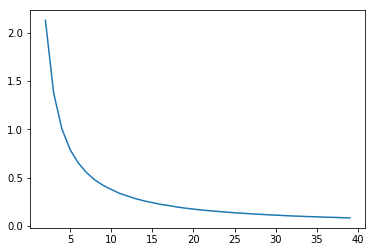

In [21]:
distances = elbow_plot(features, clusters2test = 40)

In [22]:
len(distances)

38

In [23]:
second_diff = np.diff(np.diff(distances))

In [24]:
second_diff

array([ 3.83471565e-01,  1.55674232e-01,  7.54226758e-02,  4.05347993e-02,
        2.34958447e-02,  2.00723645e-02,  1.23357280e-02,  3.37379517e-03,
        1.09117181e-02,  1.43767577e-03,  5.00117709e-03,  4.91524368e-03,
       -8.11080923e-04,  6.15569589e-03, -3.04809473e-03,  3.81236256e-03,
        1.45741941e-03,  3.45640306e-04,  1.86826153e-03,  6.71158921e-04,
        4.34445356e-04, -2.51259917e-05,  1.57253451e-03, -6.49557837e-04,
        9.03709225e-04,  2.29171073e-04,  5.76436895e-04, -1.43046705e-04,
        1.49840103e-04,  7.03993352e-04, -6.40060437e-05,  1.27581006e-03,
       -1.44696853e-03,  1.78330921e-03, -1.50139873e-03,  6.72781697e-04])

In [25]:
if second_diff[0] > 0:
    m_sign = 1
else:
    m_sign = 0
cluster_index = 0
for idx, elem in enumerate(second_diff):
    if (elem > 0 and m_sign == 0) or (elem < 0 and m_sign == 1):
        cluster_index = idx
        break
print(cluster_index)

12


In [26]:
Kmeans = KMeans(n_clusters = cluster_index).fit(features)

In [27]:
cluster_number = pd.DataFrame(Kmeans.predict(features), columns = ['ClusterNumber'])
cluster_number

ClusterNumber
0                   8
1                  11
2                   7
3                  11
4                  11
...               ...
113783              4
113784              4
113785              8
113786              7
113787              7

[113788 rows x 1 columns]

In [28]:
type(cluster_number['ClusterNumber'].tolist()[0])

int

In [29]:
cluster_data['ClusterNumber'] = cluster_number['ClusterNumber'].tolist()

In [30]:
cluster_data[:10]

Unnamed: 0                product            sessionId  \
0           0  /voicebot_codensa_b2c  2-1578082323.601250   
1           1  /voicebot_codensa_b2c  1-1578082408.737052   
2           2  /voicebot_codensa_b2c  2-1578082580.601341   
3           3  /voicebot_codensa_b2c  2-1578082699.601374   
4           4  /voicebot_codensa_b2c  2-1578082796.601402   
5           5  /voicebot_codensa_b2c  2-1578082849.601415   
6           6  /voicebot_codensa_b2c  1-1578082867.737243   
7           7  /voicebot_codensa_b2c  2-1578082931.601438   
8           8  /voicebot_codensa_b2c  1-1578082985.737287   
9           9  /voicebot_codensa_b2c  1-1578083095.737341   

                                               _text   templateId  id  \
0                                    no hay servicio  emergencias   2   
1  escorpion corte de energia desde las 8 de la m...  emergencias   8   
2  estoy llamando la Vereda campo municipal capar...  emergencias  19   
3  y casi todos los dias estamos sin luz en el pr...  emergencias  30   
4  hay muchos cortes de energia constantes bajone...  emergencias  37   
5                                     no hay energia  emergencias  43   
6                             problemas del servicio  emergencias  47   
7                                       corte de luz  emergencias  52   
8  lo que pasa es que tengo un problema con la va...  emergencias  58   
9                               falla en el servicio  emergencias  76   

                               time         name      diff        clase  \
0  2020-01-03 15:13:10.036557-05:00  Emergencias  0.485171  Emergencias   
1  2020-01-03 15:14:48.127871-05:00  Emergencias  0.259904  Emergencias   
2  2020-01-03 15:17:50.659319-05:00  Emergencias  0.340897  Emergencias   
3  2020-01-03 15:19:38.406214-05:00  Emergencias  0.255137  Emergencias   
4  2020-01-03 15:21:22.117893-05:00  Emergencias  0.099053  Emergencias   
5  2020-01-03 15:22:05.147743-05:00  Emergencias  0.428879  Emergencias   
6  2020-01-03 15:22:30.122180-05:00  Emergencias  0.393107  Emergencias   
7  2020-01-03 15:23:18.158533-05:00  Emergencias  0.397747  Emergencias   
8  2020-01-03 15:24:22.121047-05:00  Emergencias  0.106807  Emergencias   
9  2020-01-03 15:26:19.747221-05:00  Emergencias  0.682655  Emergencias   

                                               lemma  ClusterNumber  
0                                  no haber servicio              8  
1  escorpion corte energia manana ser manana solu...             11  
2  estar llamar vereda campo municipal caparrapi ...              7  
3   casi dia estar luz primero ser hora ahora vez no             11  
4  haber cortes energia constantes bajones luz po...             11  
5                                   no haber energia              3  
6                                  problema servicio              8  
7                                          corte luz              5  
8  paso ser que tener problema vaina energia hace...             11  
9                                     fallo servicio              9

In [31]:
filename_cluster = 'chat_lemma_cluster.csv'

In [32]:
cluster_data.to_csv(filename_cluster)

In [82]:
cluster_data['ClusterNumber'].value_counts().to_frame().to_csv('count_in_cluster.csv')
cluster_data['ClusterNumber'].value_counts().to_frame()

ClusterNumber
11          28632
7           21643
6           11908
8           11796
3           10684
1            8152
9            7566
10           3926
0            3592
4            2335
2            2154
5            1400

In [34]:
cluster_to_train = cluster_data[['_text', 'lemma', 'ClusterNumber']].rename(columns = {'lemma' : 'iteration', 'ClusterNumber' : 'label'})

In [35]:
cluster_data.shape

(113788, 12)

In [36]:
cluster_to_train.shape

(113788, 3)

In [ ]:
cluster_data[:10]

In [ ]:
cluster_to_train[:10]

In [ ]:
cluster_to_train.shape

In [37]:
cluster_to_train.label = cluster_to_train.label.apply(lambda x: str(x))
cluster_to_train = cluster_to_train.dropna()
cluster_to_train.shape

(113737, 3)

In [38]:
cluster_to_train[:10]

_text  \
0                                    no hay servicio   
1  escorpion corte de energia desde las 8 de la m...   
2  estoy llamando la Vereda campo municipal capar...   
3  y casi todos los dias estamos sin luz en el pr...   
4  hay muchos cortes de energia constantes bajone...   
5                                     no hay energia   
6                             problemas del servicio   
7                                       corte de luz   
8  lo que pasa es que tengo un problema con la va...   
9                               falla en el servicio   

                                           iteration label  
0                                  no haber servicio     8  
1  escorpion corte energia manana ser manana solu...    11  
2  estar llamar vereda campo municipal caparrapi ...     7  
3   casi dia estar luz primero ser hora ahora vez no    11  
4  haber cortes energia constantes bajones luz po...    11  
5                                   no haber energia     3  
6                                  problema servicio     8  
7                                          corte luz     5  
8  paso ser que tener problema vaina energia hace...    11  
9                                     fallo servicio     9

In [39]:
Tfidf = TfidfVec()
Tfidf._embedding = TfidfVectorizer(ngram_range=(1, 4),
                                   norm='l2',
                                   min_df=10,
                                   max_df=0.5,          
                                   tokenizer=None,
                                   strip_accents=None,
                                   lowercase=False)
clasifier = ShallowModel('tfidf')
clasifier._vectorizer = Tfidf
clasifier._preprocessing = None
# clasifier.fit(cluster_to_train)

/opt/conda/envs/nlp/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Number of features: 24966


SPLIT

Size of training set:     79615          
Size of validation set:   17061          
Size of test set:         17061          

TRAINING RESULTS


Accuracy:
0.90
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      2545
           1       0.86      0.93      0.90      5757
          10       0.78      0.99      0.87      2731
          11       0.95      0.82      0.88     19995
           2       0.68      1.00      0.81      1512
           3       0.89      0.94      0.91      7491
           4       0.84      0.99      0.91      1630
           5       0.80      1.00      0.89       973
           6       0.87      0.88      0.87      8385
           7       0.94      0.85      0.90     15078
           8       0.90      0.95      0.92      8206
           9       0.93      0.99      0.96      5312

    accuracy                           0.90     79615
   macro avg       0.86      0.94      0.90   

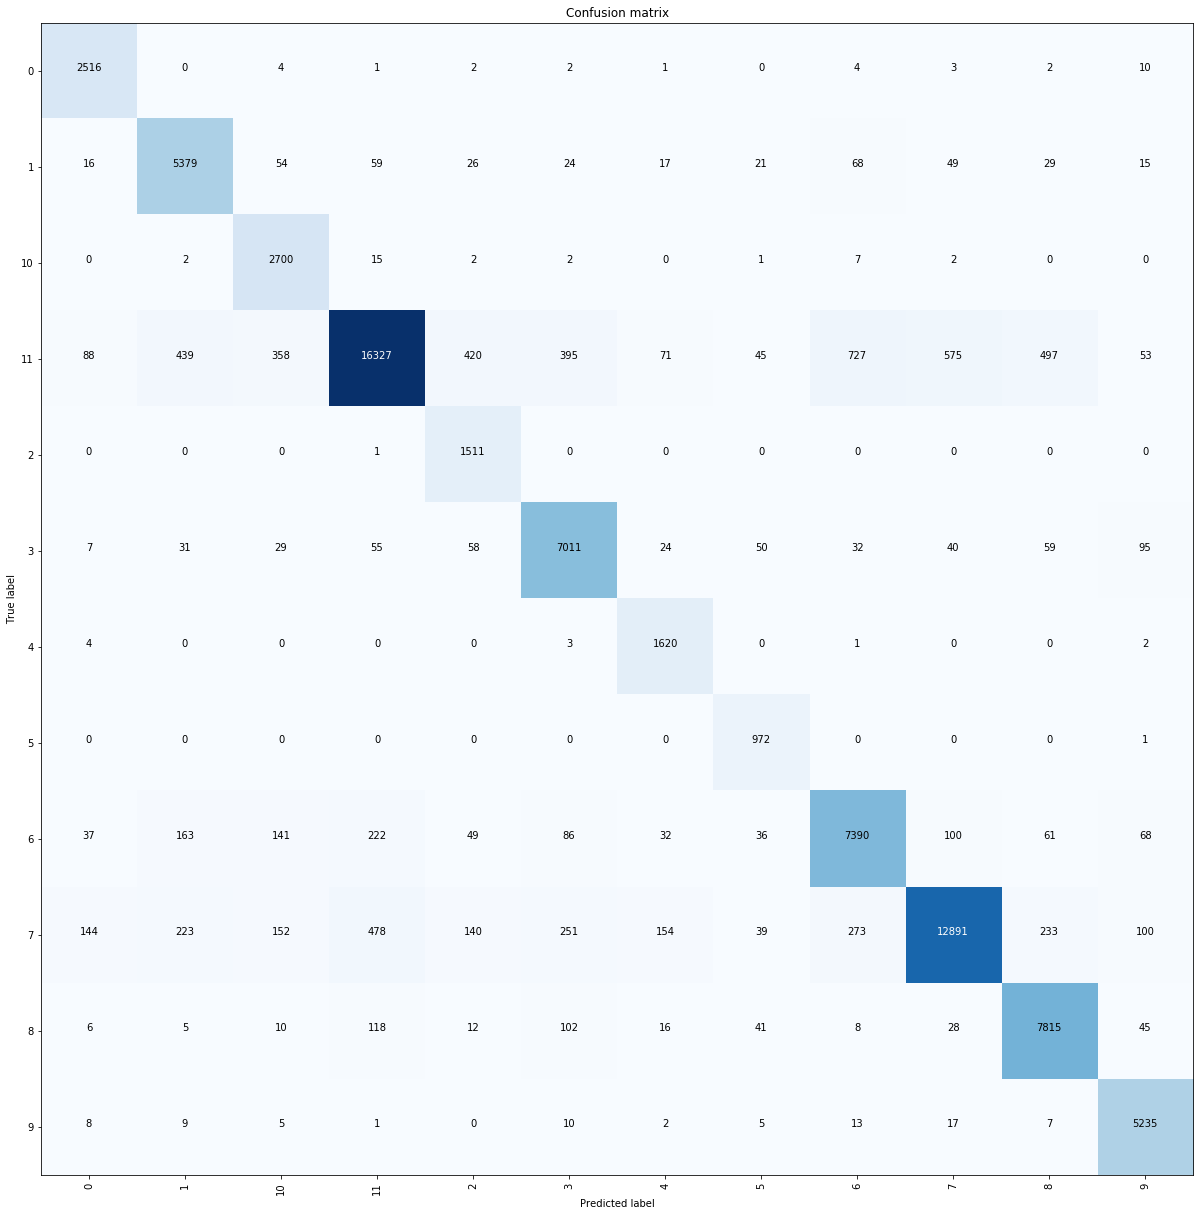


TESTING RESULTS


Accuracy:
0.86
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       527
           1       0.82      0.88      0.85      1190
          10       0.77      0.94      0.85       607
          11       0.91      0.78      0.84      4336
           2       0.62      0.94      0.75       295
           3       0.88      0.92      0.90      1655
           4       0.79      0.97      0.87       351
           5       0.78      1.00      0.88       212
           6       0.81      0.83      0.82      1763
           7       0.91      0.84      0.87      3215
           8       0.88      0.93      0.90      1778
           9       0.91      0.96      0.94      1132

    accuracy                           0.86     17061
   macro avg       0.83      0.91      0.86     17061
weighted avg       0.87      0.86      0.86     17061



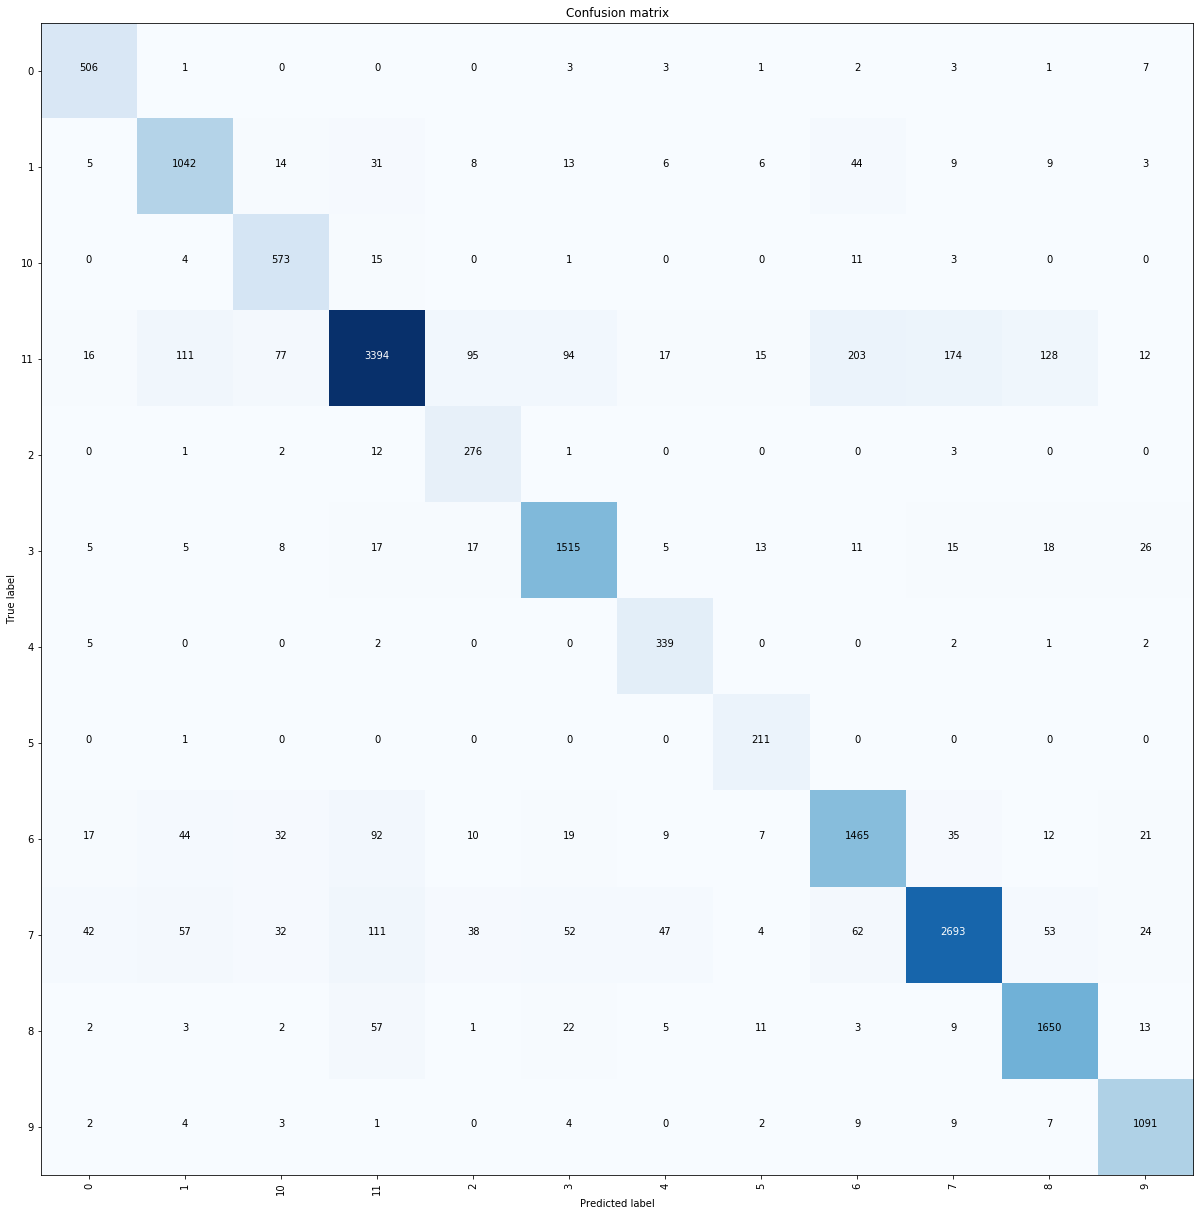

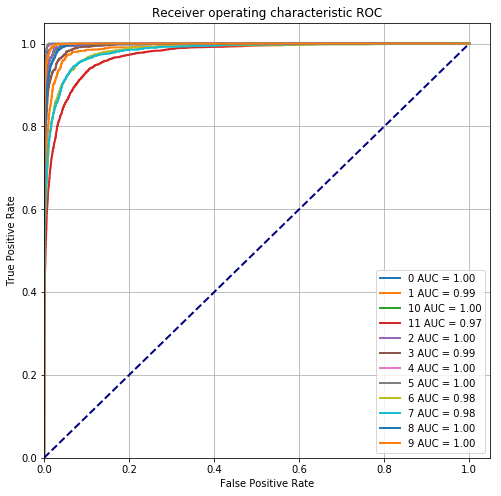

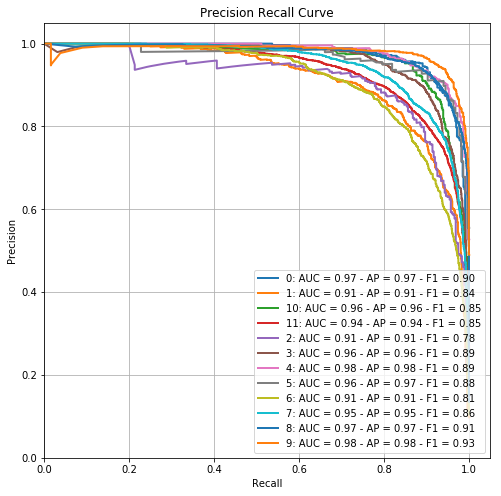


VALIDATION RESULTS

Threshold
[0.06, 0.15, 0.1, 0.16, 0.16, 0.1, 0.22, 0.06, 0.18, 0.16, 0.18, 0.11]


class  false positive rate  true positive rate
0      0             0.016867            0.990385
1      1             0.052283            0.970954
2     10             0.031870            0.991497
3     11             0.105799            0.938851
4      2             0.023992            0.988473
5      3             0.052438            0.980494
6      4             0.007901            0.994350
7      5             0.010210            1.000000
8      6             0.076596            0.950568
9      7             0.069830            0.945741
10     8             0.032789            0.983996
11     9             0.018006            0.991087


TESTING RESULTS



class  false positive rate  true positive rate
0      0             0.002056            0.924099
1      1             0.002331            0.619328
2     10             0.004619            0.881384
3     11             0.001965            0.456873
4      2             0.003340            0.823729
5      3             0.003375            0.802417
6      4             0.001735            0.874644
7      5             0.001424            0.924528
8      6             0.001242            0.484402
9      7             0.002383            0.569207
10     8             0.003599            0.800337
11     9             0.002323            0.893110

In [40]:
clasifier.fit(cluster_to_train)

In [ ]:
cluster_to_train[:10]

In [ ]:
cluster_to_train.shape

In [ ]:
type(cluster_to_train.label[0])

In [ ]:
data_tmp = cluster_to_train.label == str(2)

In [ ]:
data_tmp[:10]

In [ ]:
i_tmp = 2
for review in cluster_to_train[cluster_to_train.label == str(i_tmp)].iteration.tolist():
    print(review)
    break

Cluster 0


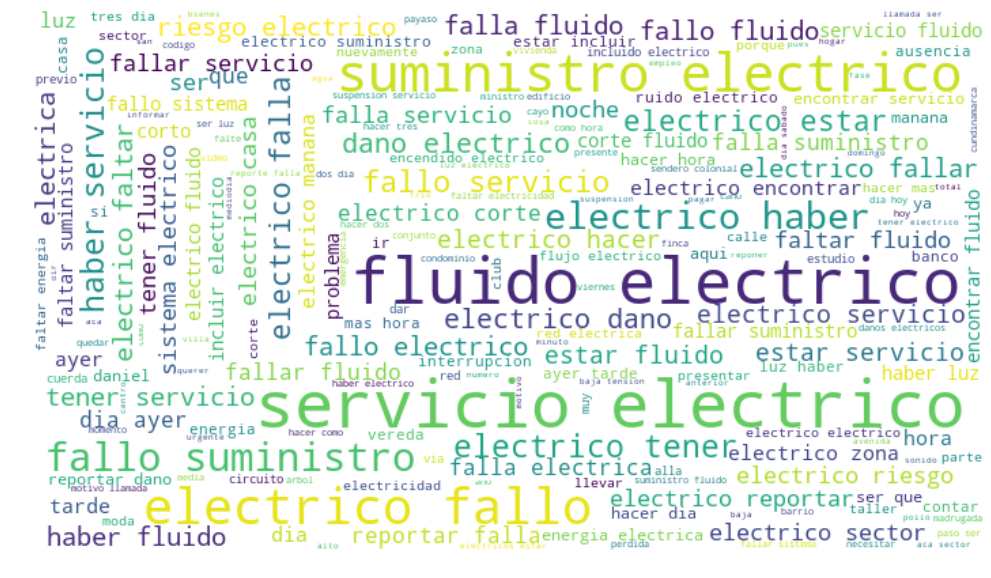

Cluster 1


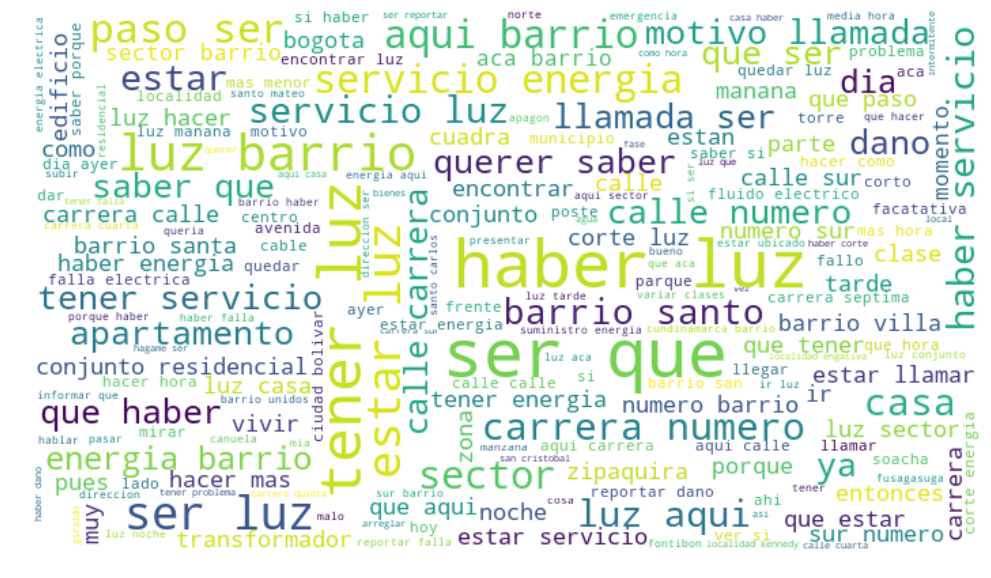

Cluster 2


Cluster 3


Cluster 4


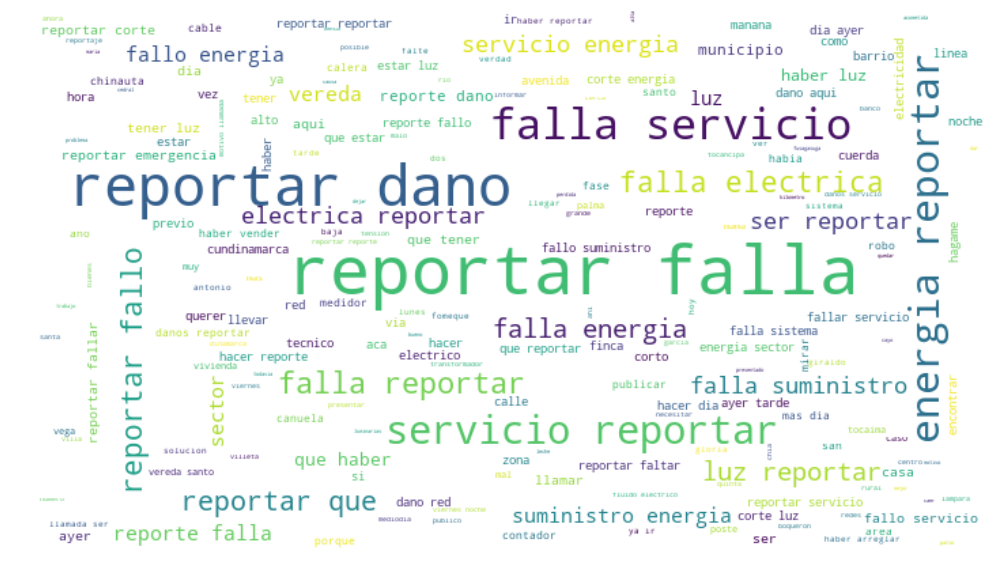

Cluster 5


Cluster 6


Cluster 7


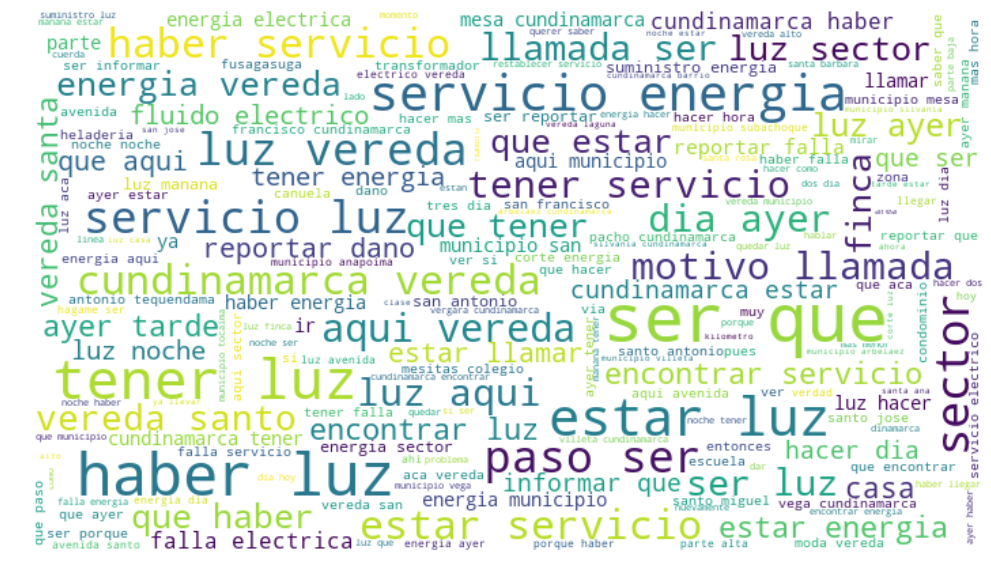

Cluster 8


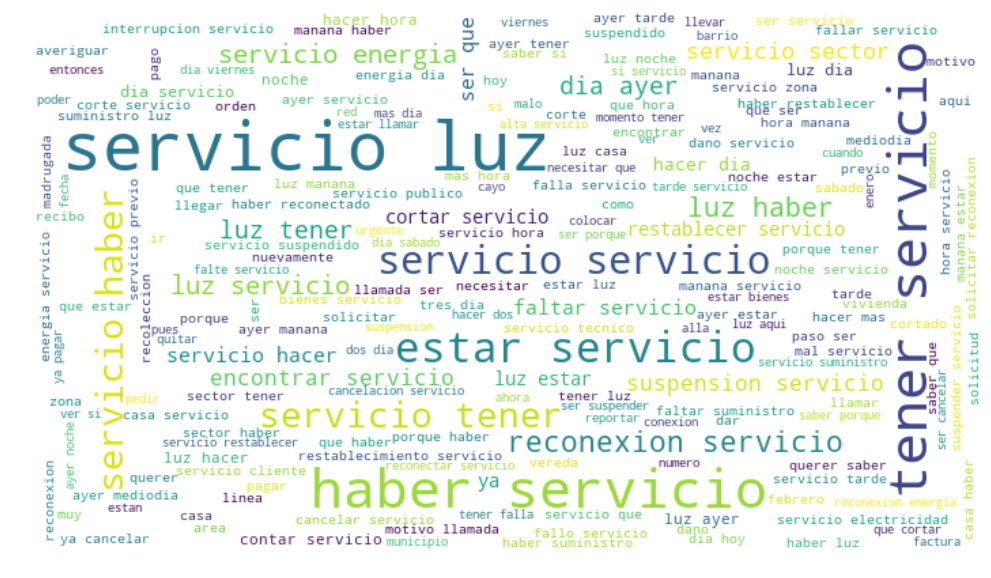

Cluster 9


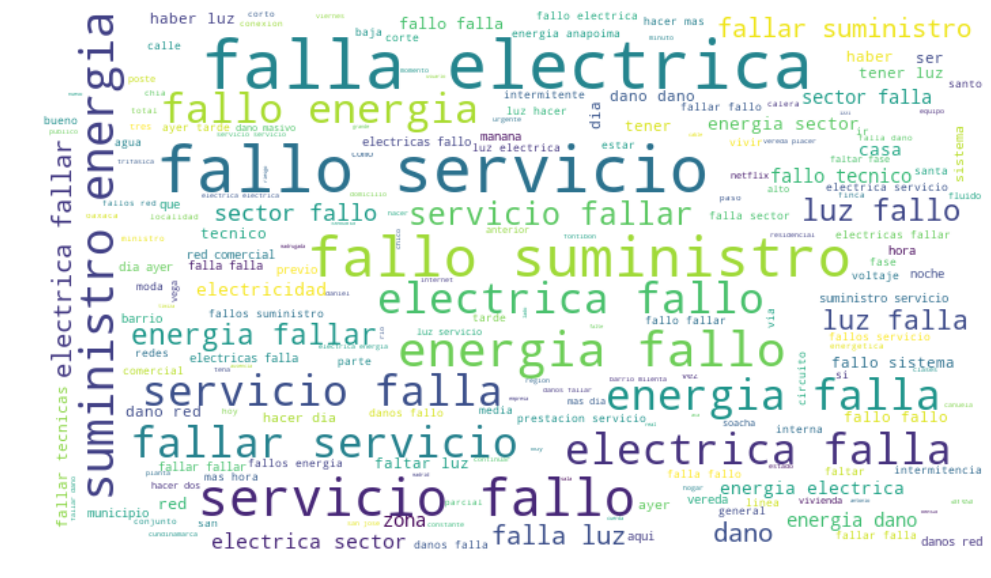

Cluster 10


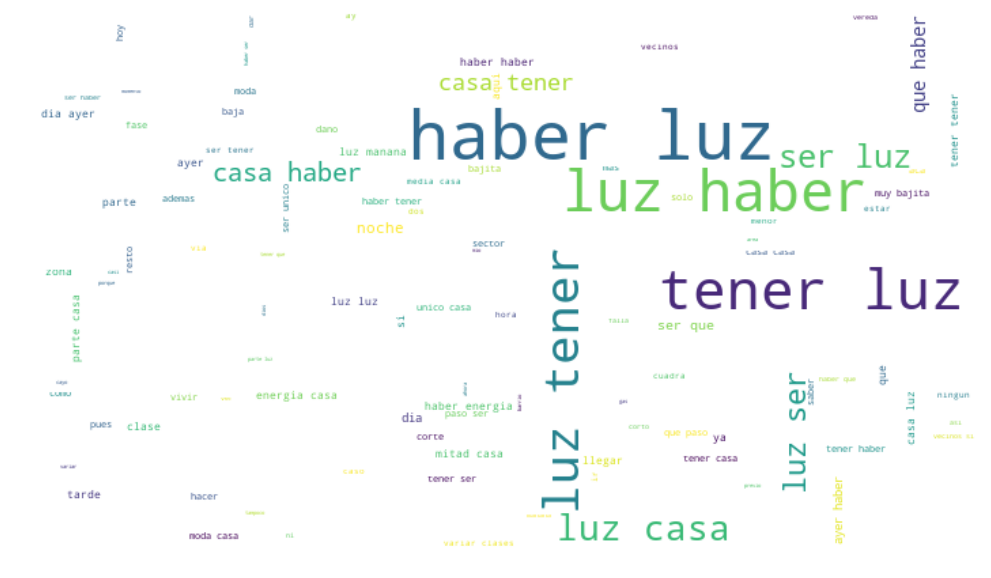

Cluster 11


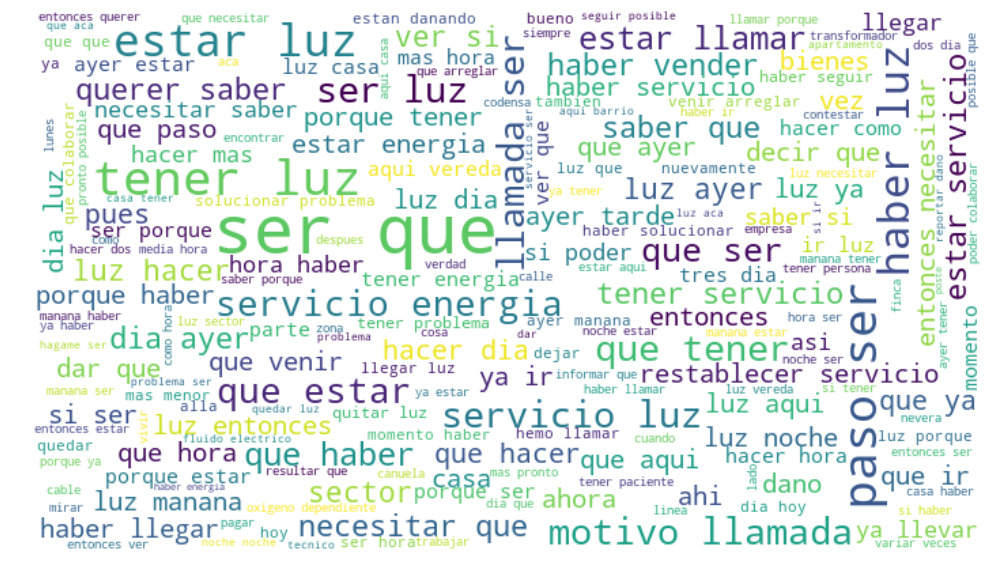

In [74]:
for i in range(cluster_index):
    try:
        print('Cluster {}'.format(i))
        plot_word_cloud(" ".join(review for review in cluster_to_train[cluster_to_train.label == str(i)].iteration.tolist()),str(i))
    except:
        pass

In [42]:
vocab_per_cluster = pd.DataFrame()
for cluster in range(cluster_index):
    try:
        vocab_per_cluster['Cluster {}: Words'.format(cluster)] = vocabulary(clasifier, str(cluster)).feature.tolist()
        vocab_per_cluster['Cluster {}: Coeffs'.format(cluster)] = vocabulary(clasifier, str(cluster))[str(cluster)].tolist()
    except:
        pass
vocab_per_cluster

Cluster 0: Words  Cluster 0: Coeffs Cluster 1: Words  \
0                  electrico              22.07           barrio   
1                  electrica               7.58          carrera   
2                 electricos               5.47            calle   
3         servicio electrico               5.23        localidad   
4       suministro electrico               3.66         conjunto   
...                      ...                ...              ...   
24961  electrico apartamento              -1.56          energia   
24962              municipio              -1.62           vereda   
24963                 barrio              -1.81        municipio   
24964                    luz              -2.94             ayer   
24965                energia              -3.02         servicio   

       Cluster 1: Coeffs Cluster 2: Words  Cluster 2: Coeffs  \
0                  17.73            estar              14.84   
1                  13.71           manana               6.73   
2                  10.96        estar luz               6.60   
3                   9.98    estar energia               5.45   
4                   9.58            noche               4.96   
...                  ...              ...                ...   
24961              -2.41               no              -2.96   
24962              -2.70           vereda              -2.99   
24963              -2.89            tener              -3.32   
24964              -2.90            haber              -3.70   
24965              -3.80         servicio              -5.47   

             Cluster 3: Words  Cluster 3: Coeffs    Cluster 4: Words  \
0                     energia              18.89            reportar   
1            servicio energia               6.03             reporte   
2                    energias               4.97      reportar falla   
3      estar servicio energia               2.96            reportes   
4          suministro energia               2.86           reportaje   
...                       ...                ...                 ...   
24961                reportar              -2.63               tener   
24962                  barrio              -2.64           necesitar   
24963            cundinamarca              -2.72               estar   
24964               municipio              -2.83  necesitar reportar   
24965                   falla              -2.98           electrico   

       Cluster 4: Coeffs  ... Cluster 7: Words  Cluster 7: Coeffs  \
0                  20.90  ...        municipio              17.29   
1                  11.16  ...     cundinamarca              16.09   
2                   4.49  ...           vereda              15.70   
3                   4.33  ...           sector               6.97   
4                   4.31  ...          avenida               6.19   
...                  ...  ...              ...                ...   
24961              -2.06  ...         servicio              -2.30   
24962              -2.08  ...            calle              -2.36   
24963              -2.96  ...         entonces              -2.60   
24964              -3.21  ...          carrera              -2.90   
24965              -3.27  ...             casa              -3.19   

      Cluster 8: Words  Cluster 8: Coeffs Cluster 9: Words  Cluster 9: Coeffs  \
0             servicio              21.63            falla              13.44   
1           reconexion               6.16           fallar              12.41   
2           suministro               4.02            fallo              12.29   
3             cancelar               3.73             dano               6.27   
4         servicio luz               3.62            danos               5.09   
...                ...                ...              ...                ...   
24961         reportar              -2.93            estar              -3.07   
24962            fallo              -3.01            haber              -3.09   
249

In [ ]:
vocab_per_cluster[:100]

In [81]:
for label_test in range(cluster_index):
    foldername = 'with_stopwords/cluster_{}'.format(label_test)
    if not os.path.exists(foldername):
        os.makedirs(foldername)
    for idx_feature in range(10):
        graph = create_adjacency_graph(data_set = cluster_to_train,
                                       model = clasifier,
                                       label = str(label_test),
                                       num_features = idx_feature,
                                       per_class = True,
                                       levels = 2)
        filename = os.path.join(foldername, 'cluster_{}_feature_{}'.format(label_test, idx_feature))
        graph.render(filename)

In [54]:
'''
idx_ = 11
graph = create_adjacency_graph(data_set = cluster_to_train,
                               model = clasifier,
                               label = str(idx_),
                               num_features = 5,
                               per_class = True,
                               levels = 2)
graph.render('test_render_{}_V{}'.format(idx_, num_features))
'''

'test_render_11_V4.pdf'

In [47]:
vocab_per_cluster[['Cluster {}: Words'.format(x) for x in range(cluster_index)]][:20]

Cluster 0: Words Cluster 1: Words     Cluster 2: Words  \
0                  electrico           barrio                estar   
1                  electrica          carrera               manana   
2                 electricos            calle            estar luz   
3         servicio electrico        localidad        estar energia   
4       suministro electrico         conjunto                noche   
5   faltar energia electrica           numero                  dia   
6           fluido electrico      residencial                tarde   
7        faltar electricidad        zipaquira                   ir   
8                   ausencia       facatativa            estar ser   
9                     fluido        direccion                  hoy   
10          danos electricos           soacha           estar aqui   
11                    faltar           ciudad                 hora   
12              electricidad        chapinero              que dia   
13                electricas      apartamento         estar bienes   
14                     malla          manzana           llevar dia   
15           fallo electrico         edificio                  luz   
16            faltar energia             aqui  estar energia hacer   
17                      club         fontibon                  mia   
18     tener falla electrica          giraldo                 ayer   
19         sistema electrico     urbanizacion      estar luz hacer   

             Cluster 3: Words Cluster 4: Words     Cluster 5: Words  \
0                     energia         reportar                corte   
1            servicio energia          reporte                corto   
2                    energias   reportar falla               cortes   
3      estar servicio energia         reportes               cortar   
4          suministro energia        reportaje            corte luz   
5                   presentar    reportar dano                tacos   
6                electricidad     reportar que            corto luz   
7               tener energia        reportada        corte energia   
8              llevar dia luz   reportar fallo        corto energia   
9           energia electrica              ano       cortar energia   
10      faltar suministro luz    reporte falla       corte servicio   
11      servicio electricidad             dano          cortar dano   
12           no tener energia        reportado           corto casa   
13     tener servicio energia            falla              cortada   
14                      tener  reportar que no             muy baja   
15              haber energia   reportar corte       corto servicio   
16          servicio energias   presentar dano       cortes energia   
17                     llevar          reclamo        corto ser luz   
18  no tener servicio energia      luis sector           cortes luz   
19          que estar energia    reporte fallo  corte energia hacer   

     Cluster 6: Words Cluster 7: Words    Cluster 8: Words  Cluster 9: Words  \
0       transformador        municipio            servicio             falla   
1            contador     cundinamarca          reconexion            fallar   
2              cables           vereda          suministro             fallo   
3             cuerdas           sector            cancelar              dano   
4         apartamento          avenida        servicio luz             danos   
5               cable            finca          suspendido            fallos   
6          emergencia        encontrar                ayer   falla electrica   
7   electrodomesticos        heladeria      estar servicio        faltar luz   
8           corriente       fusagasuga           suspender   fallar servicio   
9            entonces            santo                pago         falla luz   
10              poste        dinamarca      tener servicio               red   
11             cuerda       subachoque     cortar servicio    fallo servicio   
12       

In [48]:
cluster_to_train[:10]

_text  \
0                                    no hay servicio   
1  escorpion corte de energia desde las 8 de la m...   
2  estoy llamando la Vereda campo municipal capar...   
3  y casi todos los dias estamos sin luz en el pr...   
4  hay muchos cortes de energia constantes bajone...   
5                                     no hay energia   
6                             problemas del servicio   
7                                       corte de luz   
8  lo que pasa es que tengo un problema con la va...   
9                               falla en el servicio   

                                           iteration label  
0                                  no haber servicio     8  
1  escorpion corte energia manana ser manana solu...    11  
2  estar llamar vereda campo municipal caparrapi ...     7  
3   casi dia estar luz primero ser hora ahora vez no    11  
4  haber cortes energia constantes bajones luz po...    11  
5                                   no haber energia     3  
6                                  problema servicio     8  
7                                          corte luz     5  
8  paso ser que tener problema vaina energia hace...    11  
9                                     fallo servicio     9

In [95]:
count_elems_in_cluster = cluster_data['ClusterNumber'].value_counts().to_frame()
count_elems_in_cluster

ClusterNumber
11          28632
7           21643
6           11908
8           11796
3           10684
1            8152
9            7566
10           3926
0            3592
4            2335
2            2154
5            1400

In [103]:
count_elems_in_cluster.loc[11, 'ClusterNumber']

numpy.int64

In [130]:
total_num = count_elems_in_cluster.loc[:, 'ClusterNumber'].sum()
for i in range(cluster_index):
    num_i = count_elems_in_cluster.loc[i, 'ClusterNumber']
    print('Cluster {}: {}/{} -> {}'.format(i, num_i, total_num, float(num_i)/total_num * 100))

Cluster 0: 3592/113788 -> 3.156747635954582
Cluster 1: 8152/113788 -> 7.164200091398039
Cluster 2: 2154/113788 -> 1.892993988821317
Cluster 3: 10684/113788 -> 9.389390796920589
Cluster 4: 2335/113788 -> 2.0520617288290506
Cluster 5: 1400/113788 -> 1.23035821000457
Cluster 6: 11908/113788 -> 10.465075403381729
Cluster 7: 21643/113788 -> 19.02045909937779
Cluster 8: 11796/113788 -> 10.366646746581361
Cluster 9: 7566/113788 -> 6.64920729778184
Cluster 10: 3926/113788 -> 3.450275951769958
Cluster 11: 28632/113788 -> 25.162583049179176


113788

In [61]:
tmp_cluster_to_train = cluster_to_train

In [62]:
tmp_cluster_to_train.shape

(113737, 3)

In [207]:
data_validate = tmp_cluster_to_train[tmp_cluster_to_train['label'] == str(11)]

In [208]:
data_validate[:5]

_text  \
1   escorpion corte de energia desde las 8 de la m...   
3   y casi todos los dias estamos sin luz en el pr...   
4   hay muchos cortes de energia constantes bajone...   
8   lo que pasa es que tengo un problema con la va...   
10  no tenemos servicio de energia en la Vereda oz...   

                                            iteration label  
1   escorpion corte energia manana ser manana solu...    11  
3    casi dia estar luz primero ser hora ahora vez no    11  
4   haber cortes energia constantes bajones luz po...    11  
8   paso ser que tener problema vaina energia hace...    11  
10  no tener servicio energia vereda ozuna no no c...    11

In [209]:
cluster_11_text = data_validate.loc[:, '_text'].tolist()

In [211]:
counter = 0
for idx, text in enumerate(cluster_11_text):
    if idx > 10:
        print(text)
        print('---------')
        counter += 1
    if counter > 11:
        break

que desde esta manana a las 10:00 de la manana Se fue la luz en en unas casas y en otras no y yo uso de oxigeno 24 horas y estoy ahogada y no tengo como irme a aprender oxigeno en otro lado ,  Que tengo que hacer ante eso senor
---------
no tio la llamada Es que estamos sin luz en accion hms cortaron la luz y no hablando despues te habian dicho que 15 dias venian y no la han colocado
---------
desde el 1deg de enero no tengo servicio de Electricidad se saca una muela Si esta al lado carretera o sea es que suban y suban la canela ya no esta demorado se me hace incomodo que usted no yo mando por este servicio de a tres dias y no me soluciona nada
---------
y hagame un favor Es que yo desde primero sin servicio de Electricidad y necesito que me solucione porque tengo una persona con oxigeno que tiene que usar oxigeno todo el dia Ya la pipeta se me acabo y es una canuela esta ahi en toda la calle en toda la entrada de la calle Ahi esta la calle la calle 3 y me puedan solucionar algo Porque

In [64]:
cluster_grouped = cluster_to_train

In [69]:
type(cluster_grouped)

pandas.core.frame.DataFrame

In [71]:
cluster_grouped.loc[(cluster_to_train['label'] == str(11)) , 'label']

1         11
3         11
4         11
8         11
10        11
          ..
113762    11
113763    11
113771    11
113777    11
113778    11
Name: label, Length: 28632, dtype: object